In [1]:
# best acc: (resnet-56: val-92.15%， test-90.11%)
# best acc: (resnet-110: val-95.00%， test-(93.91%))
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
from torchsummary import summary

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

device = torch.device('cuda')
torch.cuda.set_device(7)

In [2]:
NUM_TRAIN = 48000
print_every = 370

transform_train = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=128,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=100, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
def check_accuracy_part34(loader, model, device=device):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_part34(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Epoch:(%d) Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

def train(model, optimizer, epochs=1, scheduler=None, device=device):
    model = model.to(device)  # move the model parameters to CPU/GPU
#     summary(model, (3, 32, 32))
    best_acc = 0
    best_ep = 0
    loss_his = []
    acc_his = []
    for e in range(epochs):
        if scheduler is not None:
            scheduler.step()
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t>0 and t % print_every == 0:
                loss_his.append(loss)
                model.eval()
                print('Epoch:(%d/%d) Iteration %d, loss = %.4f' % (e, epochs, t, loss.item()))
                acc = check_accuracy_part34(loader_val, model, device=device)
                acc_his.append(acc)
                if acc > best_acc:
                    best_acc = acc
                    best_ep = e
                print()
                model.train()
    return best_acc, best_ep, loss_his, acc_his

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.flag = in_channels != out_channels
        if self.flag:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=padding, bias=False)
            self.short_cut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=2, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
            self.short_cut = nn.Sequential()
            
        nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding, bias=False)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        layer1 = self.conv1(F.relu(self.bn1(x)))
        layer2 = self.conv2(F.relu(self.bn2(layer1)))
        
        if self.flag:
            out = layer2 + self.short_cut(x)
        else:
            out = layer2 + x
        return out

class Bottleneck(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size):
        super().__init__()
        padding = (kernel_size - 1) // 2
        middle_channel = out_channel // 4
        self.flag = in_channel != out_channel
        self.conv1 = nn.Conv2d(in_channel, middle_channel, 1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(middle_channel)
        
        if self.flag:
            self.conv2 = nn.Conv2d(middle_channel, middle_channel, kernel_size, stride=2, padding=padding, bias=False)
            self.short_cut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, stride=2, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.conv2 = nn.Conv2d(middle_channel, middle_channel, kernel_size, padding=padding, bias=False)
            self.short_cut = nn.Sequential()

        self.bn2 = nn.BatchNorm2d(middle_channel)

        self.conv3 = nn.Conv2d(middle_channel, out_channel, kernel_size, padding=padding, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        
    def forward(self, x):
        residual = x

        layer1 = F.relu(self.bn1(self.conv1(x)))
        layer2 = F.relu(self.bn2(self.conv2(layer1)))
        layer3 = self.bn3(self.conv3(layer2))
        
        if self.flag:
            out = F.relu(layer3 + self.short_cut(residual))
        else:
            out = F.relu(layer3 + x)

        return out
    
    
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_layer = nn.Sequential(
#             nn.BatchNorm2d(3),
            nn.Conv2d(3, 16, 3, padding=1, bias=False)
#             nn.BatchNorm2d(16),
#             nn.ReLU(True)
#             nn.MaxPool2d(2)
        )
        
        self.layer1 = self.build_layer(16, 16, 18, BasicBlock)          # 32
        self.layer2 = self.build_layer(16, 32, 18, BasicBlock)         # 16
        self.layer3 = self.build_layer(32, 64, 18, BasicBlock)        # 8
#         self.layer4 = self.build_layer(256, 512, 3, BasicBlock)        # 4
        self.bn = nn.BatchNorm2d(64)
        self.avgpool = nn.AvgPool2d(8)
        self.classifier = nn.Linear(64, 10)
        
    def build_layer(self, in_channels, out_channels, num_blocks, block=BasicBlock):
        layers = []
        first_block = block(in_channels, out_channels, 3)
        layers.append(first_block)
        for i in range(num_blocks - 1):
            layers.append(block(out_channels, out_channels, 3))

#         layers.append(nn.Dropout2d(0.1))
        return nn.Sequential(*layers)

    def forward(self, x):
        head = self.input_layer(x)
        layer_1 = self.layer1(head)
        layer_2 = self.layer2(layer_1)
        layer_3 = F.relu(self.bn(self.layer3(layer_2)))
#         layer_4 = self.layer4(layer_3)
        out = self.avgpool(layer_3).view(x.shape[0], -1)

        return self.classifier(out)

model = ResNet()
# model = nn.DataParallel(model, device_ids=[7,0,1,2,3,4,5,6])

learning_rate = 1e-1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
best_acc, ep, loss_his, acc_his = train(model, optimizer, epochs=200, scheduler=scheduler, device=device)
print('finish2\nepoch:%d, best accuracy:%.2f%%' % (ep, best_acc*100))

Epoch:(0/200) Iteration 370, loss = 1.3242
Checking accuracy on validation set
Got 872 / 2000 correct (43.60%)

Epoch:(1/200) Iteration 370, loss = 0.9786
Checking accuracy on validation set
Got 1238 / 2000 correct (61.90%)

Epoch:(2/200) Iteration 370, loss = 0.7570
Checking accuracy on validation set
Got 1297 / 2000 correct (64.85%)

Epoch:(3/200) Iteration 370, loss = 0.7228
Checking accuracy on validation set
Got 1528 / 2000 correct (76.40%)

Epoch:(4/200) Iteration 370, loss = 0.6292
Checking accuracy on validation set
Got 1389 / 2000 correct (69.45%)

Epoch:(5/200) Iteration 370, loss = 0.6438
Checking accuracy on validation set
Got 1426 / 2000 correct (71.30%)

Epoch:(6/200) Iteration 370, loss = 0.5342
Checking accuracy on validation set
Got 1487 / 2000 correct (74.35%)

Epoch:(7/200) Iteration 370, loss = 0.6282
Checking accuracy on validation set
Got 1607 / 2000 correct (80.35%)

Epoch:(8/200) Iteration 370, loss = 0.5194
Checking accuracy on validation set
Got 1542 / 2000 co

Epoch:(72/200) Iteration 370, loss = 0.3276
Checking accuracy on validation set
Got 1690 / 2000 correct (84.50%)

Epoch:(73/200) Iteration 370, loss = 0.4277
Checking accuracy on validation set
Got 1739 / 2000 correct (86.95%)

Epoch:(74/200) Iteration 370, loss = 0.4177
Checking accuracy on validation set
Got 1699 / 2000 correct (84.95%)

Epoch:(75/200) Iteration 370, loss = 0.3284
Checking accuracy on validation set
Got 1687 / 2000 correct (84.35%)

Epoch:(76/200) Iteration 370, loss = 0.3119
Checking accuracy on validation set
Got 1679 / 2000 correct (83.95%)

Epoch:(77/200) Iteration 370, loss = 0.3246
Checking accuracy on validation set
Got 1615 / 2000 correct (80.75%)

Epoch:(78/200) Iteration 370, loss = 0.4139
Checking accuracy on validation set
Got 1430 / 2000 correct (71.50%)

Epoch:(79/200) Iteration 370, loss = 0.2704
Checking accuracy on validation set
Got 1627 / 2000 correct (81.35%)

Epoch:(80/200) Iteration 370, loss = 0.4407
Checking accuracy on validation set
Got 1624

Got 1830 / 2000 correct (91.50%)

Epoch:(144/200) Iteration 370, loss = 0.0387
Checking accuracy on validation set
Got 1826 / 2000 correct (91.30%)

Epoch:(145/200) Iteration 370, loss = 0.0374
Checking accuracy on validation set
Got 1836 / 2000 correct (91.80%)

Epoch:(146/200) Iteration 370, loss = 0.0982
Checking accuracy on validation set
Got 1782 / 2000 correct (89.10%)

Epoch:(147/200) Iteration 370, loss = 0.0859
Checking accuracy on validation set
Got 1848 / 2000 correct (92.40%)

Epoch:(148/200) Iteration 370, loss = 0.0947
Checking accuracy on validation set
Got 1856 / 2000 correct (92.80%)

Epoch:(149/200) Iteration 370, loss = 0.0743
Checking accuracy on validation set
Got 1842 / 2000 correct (92.10%)

Epoch:(150/200) Iteration 370, loss = 0.0236
Checking accuracy on validation set
Got 1876 / 2000 correct (93.80%)

Epoch:(151/200) Iteration 370, loss = 0.0338
Checking accuracy on validation set
Got 1888 / 2000 correct (94.40%)

Epoch:(152/200) Iteration 370, loss = 0.0106
C

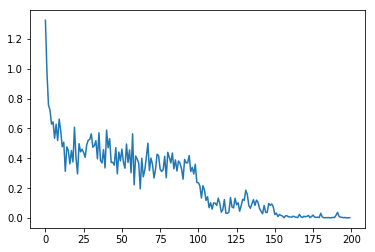

In [7]:
plt.plot(loss_his)

In [ ]:
import torchvision.models as models

class PretrainedModel(nn.Module):
    def __init__(self, state_dict=None):
        super().__init__()
        self.resnet = models.resnet101()
        self.resnet.load_state_dict(state_dict)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
        
    def forward(self, x):
        return self.resnet(x)

model_url = 'https://www.flyai.com/m/resnet101-5d3b4d8f.pth'
state_dict = torch.utils.model_zoo.load_url(model_url)

model = PretrainedModel(state_dict)

learning_rate = 1e-3
# optimizer = optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[30, 50], gamma=0.1)
best_acc, ep = train(model, optimizer, epochs=30, scheduler=scheduler, device=device)
print('finish2\nepoch:%d, best accuracy:%.2f%%' % (ep, best_acc*100))

In [5]:
check_accuracy_part34(loader_train, model)

Checking accuracy on validation set
Got 47991 / 48000 correct (99.98%)


0.9998125

In [6]:
check_accuracy_part34(loader_test, model)

Checking accuracy on test set
Got 9391 / 10000 correct (93.91%)


0.9391